In [1]:
import math
import pandas as pd
import matplotlib.pyplot as plt

from notebook_utils import *

In [2]:
df = pd.read_csv("../data/tldr_winrate_vs_human.csv")

In [3]:
df.columns

Index(['acq', 'm', 'seed', 'N', 'win_rate'], dtype='object')

In [4]:
agg_df = df.groupby(["acq", "m"]).win_rate.agg(["mean", "std", "count"])
agg_df["stderr"] = agg_df.apply(lambda r: r['std'] / r['count']**0.5, axis=1)

In [5]:
agg_df

mean       std  count    stderr
acq       m                                       
CERTAINTY 128  0.520833  0.031270      3  0.018054
          256  0.591146  0.031270      3  0.018054
          512  0.636719  0.016688      3  0.009635
          768  0.647135  0.015787      3  0.009115
ENTROPY   128  0.537760  0.025416      3  0.014674
          256  0.591797  0.023680      3  0.013672
          512  0.604818  0.014397      3  0.008312
          768  0.626953  0.013532      3  0.007812
OFFLINE   128  0.552734  0.034054      3  0.019661
          256  0.574870  0.006859      3  0.003960
          512  0.561198  0.010023      3  0.005787
          768  0.613932  0.004066      3  0.002347
RANDOM    128  0.549479  0.024264      3  0.014009
          256  0.551432  0.036557      3  0.021106
          512  0.607422  0.010875      3  0.006278
          768  0.606771  0.004915      3  0.002838

<AxesSubplot: xlabel='m'>

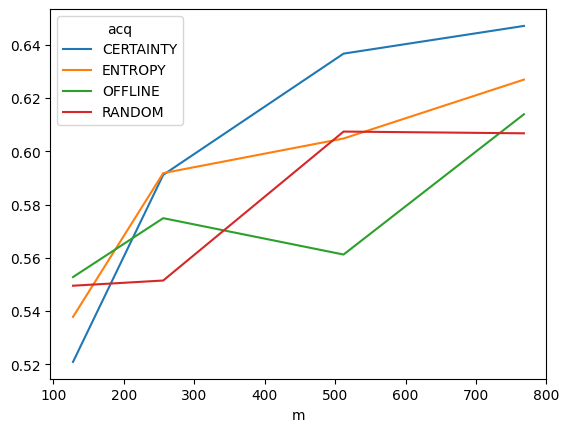

In [7]:
agg_df['mean'].unstack(level=0).plot()

In [8]:
WIN_RATE = "win_rate"
ACQ = "acq"
df_agg = df.groupby(["m", ACQ])[WIN_RATE].agg(["mean", "std", "count"]).reset_index()
df_agg['stderr'] = df_agg['std'] / df_agg['count']**0.5
display(df_agg.sort_values(['m', ACQ]))


,m,acq,mean,std,count,stderr
0,128,CERTAINTY,0.520833,0.031270,3,0.018054
1,128,ENTROPY,0.537760,0.025416,3,0.014674
2,128,OFFLINE,0.552734,0.034054,3,0.019661
3,128,RANDOM,0.549479,0.024264,3,0.014009
4,256,CERTAINTY,0.591146,0.031270,3,0.018054
5,256,ENTROPY,0.591797,0.023680,3,0.013672
6,256,OFFLINE,0.574870,0.006859,3,0.003960
7,256,RANDOM,0.551432,0.036557,3,0.021106
8,512,CERTAINTY,0.636719,0.016688,3,0.009635
9,512,ENTROPY,0.604818,0.014397,3,0.008312


/home/will/code/preference-learning/venv/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1070: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
/home/will/code/preference-learning/notebooks/notebook_utils.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"{int(x * 100)}" for x in ax.get_yticks()])


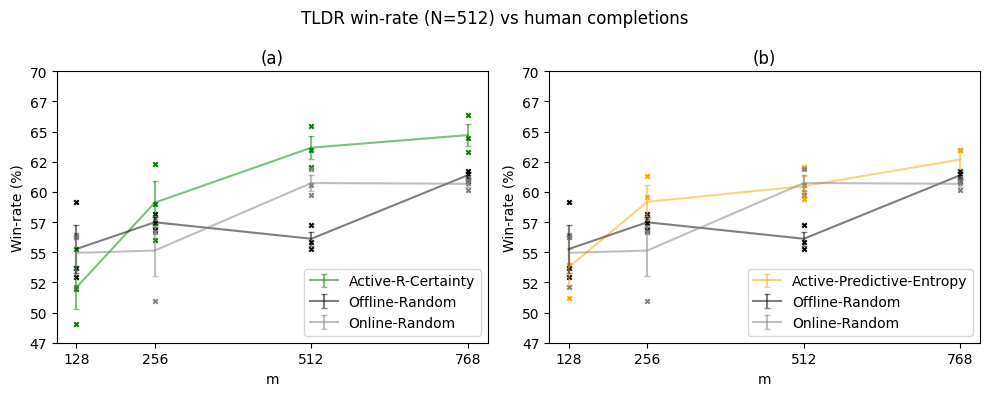

In [9]:
plot_winrate_grid(df, df_agg, 
                  [
                      ["OFFLINE", "RANDOM", "CERTAINTY"], 
                      ["OFFLINE", "RANDOM", "ENTROPY"],
                  ],
                output_path="tldr-final-vs-human.png", 
                  acq="acq",
                  title="TLDR win-rate (N=512) vs human completions",
                  figwidth=10,
                  ylim=(0.475, 0.7)                  
                 )

In [12]:
import scipy.stats as stats

agg_df = df.groupby([ACQ, "m"])[WIN_RATE].agg(["count", "mean", "std"])

for BASELINE in ["OFFLINE", "RANDOM"]:

    def do_ttest(g):
        m = g["m"].iloc[0]
        bdf = df[(df[ACQ] == BASELINE) & (df["m"] == m)]
        return stats.ttest_ind(g[WIN_RATE], bdf[WIN_RATE]).pvalue

    def diff_mean(g):
        m = g["m"].iloc[0]
        bdf = df[(df[ACQ] == BASELINE) & (df["m"] == m)]
        return g[WIN_RATE].mean() - bdf[WIN_RATE].mean()
    
    def diff_mean_std(g):
        m = g["m"].iloc[0]
        bdf = df[(df[ACQ] == BASELINE) & (df["m"] == m)]
        return (g[WIN_RATE].std()**2 + bdf[WIN_RATE].std()**2)**0.5

    agg_df[f"effect_vs_{BASELINE}"] = df.groupby([ACQ, "m"]).apply(diff_mean)
    agg_df[f"std_effect_vs_{BASELINE}"] = df.groupby([ACQ, "m"]).apply(diff_mean_std)
    agg_df[f"pvalue_vs_{BASELINE}"] = df.groupby([ACQ, "m"]).apply(do_ttest)


agg_df

count      mean       std  effect_vs_OFFLINE  \
acq       m                                                   
CERTAINTY 128      3  0.520833  0.031270          -0.031901   
          256      3  0.591146  0.031270           0.016276   
          512      3  0.636719  0.016688           0.075521   
          768      3  0.647135  0.015787           0.033203   
ENTROPY   128      3  0.537760  0.025416          -0.014974   
          256      3  0.591797  0.023680           0.016927   
          512      3  0.604818  0.014397           0.043620   
          768      3  0.626953  0.013532           0.013021   
OFFLINE   128      3  0.552734  0.034054           0.000000   
          256      3  0.574870  0.006859           0.000000   
          512      3  0.561198  0.010023           0.000000   
          768      3  0.613932  0.004066           0.000000   
RANDOM    128      3  0.549479  0.024264          -0.003255   
          256      3  0.551432  0.036557          -0.023438   
          512      3  0.607422  0.010875           0.046224   
          768      3  0.606771  0.004915          -0.007161   

               std_effect_vs_OFFLINE  pvalue_vs_OFFLINE  effect_vs_RANDOM  \
acq       m                                                                 
CERTAINTY 128               0.046233           0.298052         -0.028646   
          256               0.032014           0.428271          0.039714   
          512               0.019466           0.002554          0.029297   
          768               0.016302           0.024280          0.040365   
ENTROPY   128               0.042493           0.574602         -0.011719   
          256               0.024654           0.300125          0.040365   
          512               0.017542           0.012577         -0.002604   
          768               0.014129           0.185684          0.020182   
OFFLINE   128               0.048159           1.000000          0.003255   
          256               0.009700           1.000000          0.023438   
          512               0.014174           1.000000         -0.046224   
          768               0.005750           1.000000          0.007161   
RANDOM    128               0.041814           0.899251          0.000000   
          256               0.037195           0.336426          0.000000   
          512               0.014789           0.005641          0.000000   
          768               0.006379           0.123730          0.000000   

               std_effect_vs_RANDOM  pvalue_vs_RANDOM  
acq       m                                            
CERTAINTY 128              0.039580          0.278269  
          256              0.048107          0.225980  
          512              0.019918          0.063465  
          768              0.016534          0.013388  
ENTROPY   128              0.035138          0.594460  
          256              0.043557          0.183738  
          512              0.018042          0.814902  
          768              0.014397          0.072128  
OFFLINE   128              0.041814          0.899251  
          256              0.037195          0.336426  
          512              0.014789          0.005641  
          768              0.006379          0.123730  
RANDOM    128              0.034314          1.000000  
          256              0.051699          1.000000  
          512              0.015379          1.000000  
          768              0.006951          1.000000

In [13]:
print(agg_df[["effect_vs_OFFLINE", "std_effect_vs_OFFLINE"]].to_latex())

\begin{tabular}{llrr}
\toprule
       &     &  effect\_vs\_OFFLINE &  std\_effect\_vs\_OFFLINE \\
acq & m &                    &                        \\
\midrule
CERTAINTY & 128 &          -0.031901 &               0.046233 \\
       & 256 &           0.016276 &               0.032014 \\
       & 512 &           0.075521 &               0.019466 \\
       & 768 &           0.033203 &               0.016302 \\
ENTROPY & 128 &          -0.014974 &               0.042493 \\
       & 256 &           0.016927 &               0.024654 \\
       & 512 &           0.043620 &               0.017542 \\
       & 768 &           0.013021 &               0.014129 \\
OFFLINE & 128 &           0.000000 &               0.048159 \\
       & 256 &           0.000000 &               0.009700 \\
       & 512 &           0.000000 &               0.014174 \\
       & 768 &           0.000000 &               0.005750 \\
RANDOM & 128 &          -0.003255 &               0.041814 \\
       & 256 &          -

In [14]:
print(agg_df[["effect_vs_RANDOM", "std_effect_vs_RANDOM"]].to_latex())

\begin{tabular}{llrr}
\toprule
       &     &  effect\_vs\_RANDOM &  std\_effect\_vs\_RANDOM \\
acq & m &                   &                       \\
\midrule
CERTAINTY & 128 &         -0.028646 &              0.039580 \\
       & 256 &          0.039714 &              0.048107 \\
       & 512 &          0.029297 &              0.019918 \\
       & 768 &          0.040365 &              0.016534 \\
ENTROPY & 128 &         -0.011719 &              0.035138 \\
       & 256 &          0.040365 &              0.043557 \\
       & 512 &         -0.002604 &              0.018042 \\
       & 768 &          0.020182 &              0.014397 \\
OFFLINE & 128 &          0.003255 &              0.041814 \\
       & 256 &          0.023438 &              0.037195 \\
       & 512 &         -0.046224 &              0.014789 \\
       & 768 &          0.007161 &              0.006379 \\
RANDOM & 128 &          0.000000 &              0.034314 \\
       & 256 &          0.000000 &              0.05169

In [15]:
print(agg_df.reset_index().to_latex(index=False, float_format="%.03f"))

\begin{tabular}{lrrrrrrrrrr}
\toprule
      acq &   m &  count &  mean &   std &  effect\_vs\_OFFLINE &  std\_effect\_vs\_OFFLINE &  pvalue\_vs\_OFFLINE &  effect\_vs\_RANDOM &  std\_effect\_vs\_RANDOM &  pvalue\_vs\_RANDOM \\
\midrule
CERTAINTY & 128 &      3 & 0.521 & 0.031 &             -0.032 &                  0.046 &              0.298 &            -0.029 &                 0.040 &             0.278 \\
CERTAINTY & 256 &      3 & 0.591 & 0.031 &              0.016 &                  0.032 &              0.428 &             0.040 &                 0.048 &             0.226 \\
CERTAINTY & 512 &      3 & 0.637 & 0.017 &              0.076 &                  0.019 &              0.003 &             0.029 &                 0.020 &             0.063 \\
CERTAINTY & 768 &      3 & 0.647 & 0.016 &              0.033 &                  0.016 &              0.024 &             0.040 &                 0.017 &             0.013 \\
  ENTROPY & 128 &      3 & 0.538 & 0.025 &             -0.015 & 